In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import mne
from mne.stats import spatio_temporal_cluster_test
from mne.datasets import sample
from mne.channels import find_ch_adjacency
from mne.viz import plot_compare_evokeds

print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
event_id = {'Aud/L': 1, 'Aud/R': 2, 'Vis/L': 3, 'Vis/R': 4}
tmin = -0.2
tmax = 0.5

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.filter(1, 30, fir_design='firwin')
events = mne.read_events(event_fname)

Opening raw data file /Users/cn101458/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 497 samples (3.310 sec)



In [4]:
picks = mne.pick_types(raw.info, meg='mag', eog=True)

reject = dict(mag=4e-12, eog=150e-6)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=None, reject=reject, preload=True)

epochs.drop_channels(['EOG 061'])
epochs.equalize_event_counts(event_id)

X = [epochs[k].get_data() for k in event_id]  # as 3D matrix
X = [np.transpose(x, (0, 2, 1)) for x in X]  # transpose for clustering

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
4 projection items activated
Loading data for 288 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 

Reading adjacency matrix for neuromag306mag.
<class 'scipy.sparse.csr.csr_matrix'>


Text(0.5, 1.0, 'Between-sensor adjacency')

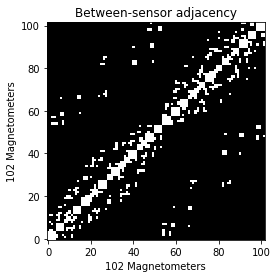

In [5]:
adjacency, ch_names = find_ch_adjacency(epochs.info, ch_type='mag')

print(type(adjacency))  # it's a sparse matrix!

plt.imshow(adjacency.toarray(), cmap='gray', origin='lower',
           interpolation='nearest')
plt.xlabel('{} Magnetometers'.format(len(ch_names)))
plt.ylabel('{} Magnetometers'.format(len(ch_names)))
plt.title('Between-sensor adjacency')

In [6]:
# set cluster threshold
threshold = 50.0  # very high, but the test is quite sensitive on this data
# set family-wise p-value
p_accept = 0.01

cluster_stats = spatio_temporal_cluster_test(X, n_permutations=1000,
                                             threshold=threshold, tail=1,
                                             n_jobs=1, buffer_size=None,
                                             adjacency=adjacency)

T_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

stat_fun(H1): min=0.004107 max=196.094418
Running initial clustering
Found 8 clusters
Permuting 999 times...



Computing cluster p-values
Done.


In [8]:
T_obs.shape

(106, 102)

ch_inds[83 90 93]
time_inds[40 41 42 43 44 45 46 47]
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


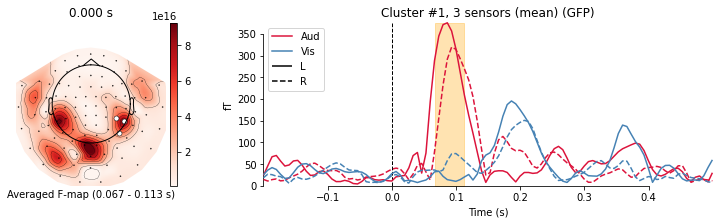

ch_inds[ 6 15 59 60 63 64 66 69 70 72 74 76 77 78 89]
time_inds[41 42 43 44 45 46 47]
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


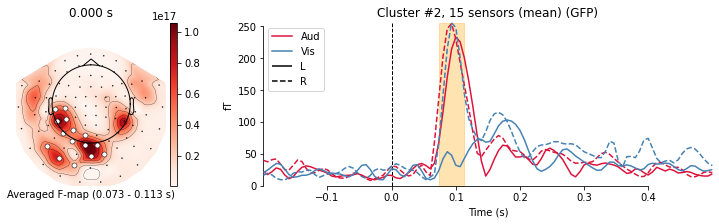

ch_inds[53]
time_inds[42 43]


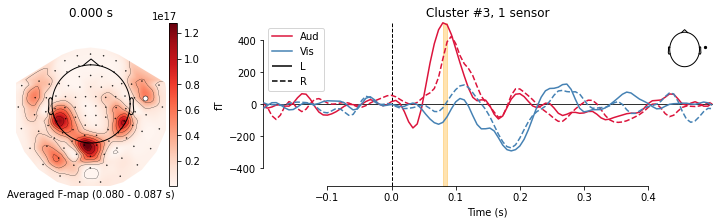

ch_inds[ 1  2 54]
time_inds[43 44 45 46]
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


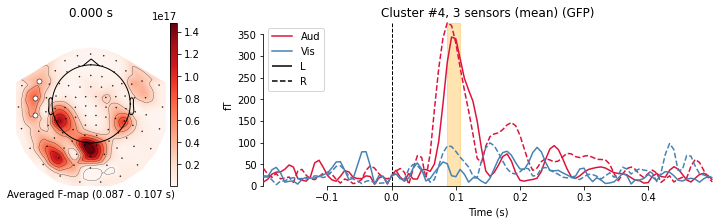

ch_inds[50]
time_inds[44]


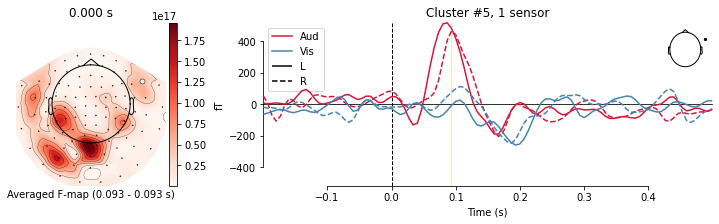

ch_inds[88 94]
time_inds[48 49 50]
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


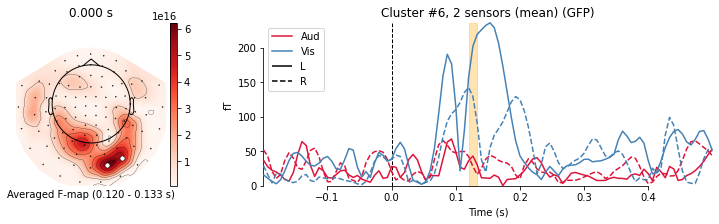

ch_inds[77]
time_inds[50 51]


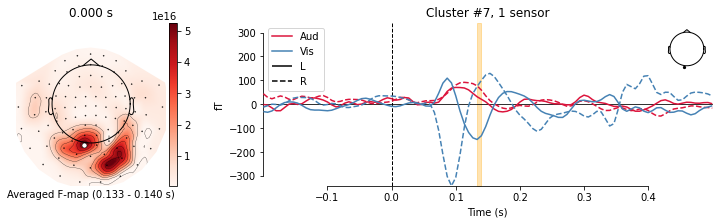

ch_inds[87]
time_inds[59 60]


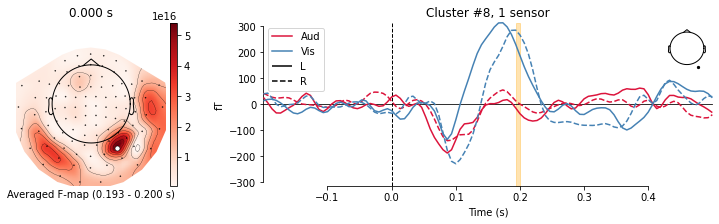

In [9]:
# configure variables for visualization
colors = {"Aud": "crimson", "Vis": 'steelblue'}
linestyles = {"L": '-', "R": '--'}

# organize data for plotting
evokeds = {cond: epochs[cond].average() for cond in event_id}

# loop over clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)
    
    print("ch_inds" + str(ch_inds))
    print("time_inds" + str(time_inds))

    # get topography for F stat
    f_map = T_obs[time_inds, ...].mean(axis=0)

    # get signals at the sensors contributing to the cluster
    sig_times = epochs.times[time_inds]

    # create spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # plot average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(f_map[:, np.newaxis], epochs.info, tmin=0)
    f_evoked.plot_topomap(times=0, mask=mask, axes=ax_topo, cmap='Reds',
                          vmin=np.min, vmax=np.max, show=False,
                          colorbar=False, mask_params=dict(markersize=10))
    image = ax_topo.images[0]

    # create additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        'Averaged F-map ({:0.3f} - {:0.3f} s)'.format(*sig_times[[0, -1]]))

    # add new axis for time courses and plot time courses
    ax_signals = divider.append_axes('right', size='300%', pad=1.2)
    title = 'Cluster #{0}, {1} sensor'.format(i_clu + 1, len(ch_inds))
    if len(ch_inds) > 1:
        title += "s (mean)"
    plot_compare_evokeds(evokeds, title=title, picks=ch_inds, axes=ax_signals,
                         colors=colors, linestyles=linestyles, show=False,
                         split_legend=True, truncate_yaxis='auto')

    # plot temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                             color='orange', alpha=0.3)

    # clean up viz
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=.05)
    plt.show()


In [10]:
ev1 = evokeds['Aud/L']

In [11]:
evokedsevokeds

NameError: name 'evokedsevokeds' is not defined

In [ ]:
ev1.info

In [ ]:
ev_df = ev1.to_data_frame(long_format=True)

In [ ]:
ev_df

In [ ]:
channels = ev1.info['ch_names']

In [ ]:
channels[87]

In [ ]:
len(channels)

In [ ]:
ch_inds[88 94]

In [ ]:
channels[88]

In [ ]:
channels[94]

In [ ]:
channels[6]

In [ ]:
channels[15]

In [ ]:
ev1.plot_sensors(kind='3d', ch_type='mag', ch_groups='position')

In [ ]:
X[0].shape

In [12]:
evokeds

{'Aud/L': <Evoked | 'Aud/L' (average, N=55), [-0.1998, 0.49949] sec, 102 ch, ~3.2 MB>,
 'Aud/R': <Evoked | 'Aud/R' (average, N=55), [-0.1998, 0.49949] sec, 102 ch, ~3.2 MB>,
 'Vis/L': <Evoked | 'Vis/L' (average, N=55), [-0.1998, 0.49949] sec, 102 ch, ~3.2 MB>,
 'Vis/R': <Evoked | 'Vis/R' (average, N=55), [-0.1998, 0.49949] sec, 102 ch, ~3.2 MB>}

In [ ]:
ch_inds[ 6 15 59 60 63 64 66 69 70 72 74 76 77 78 89]